In [ ]:
# Dataset source
# https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset/data

# Dataset Features:

#     Age | Objective Feature | age | int (days)
#     Height | Objective Feature | height | int (cm) |
#     Weight | Objective Feature | weight | float (kg) |
#     Gender | Objective Feature | gender | categorical code |
#     Systolic blood pressure | Examination Feature | ap_hi | int |
#     Diastolic blood pressure | Examination Feature | ap_lo | int |
#     Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
#     Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
#     Smoking | Subjective Feature | smoke | binary |
#     Alcohol intake | Subjective Feature | alco | binary |
#     Physical activity | Subjective Feature | active | binary |
#     Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


## IMPORTING LIBRARIES

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
from sklearn.compose import ColumnTransformer

## DATA ANALYSIS AND TRANSFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio

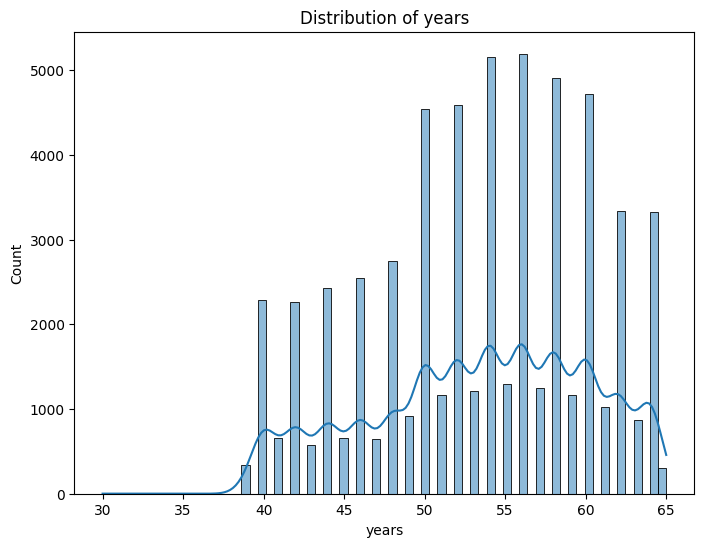

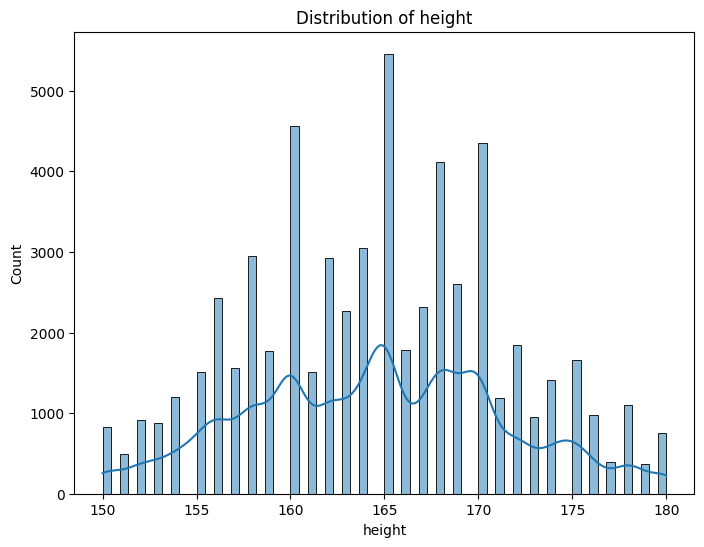

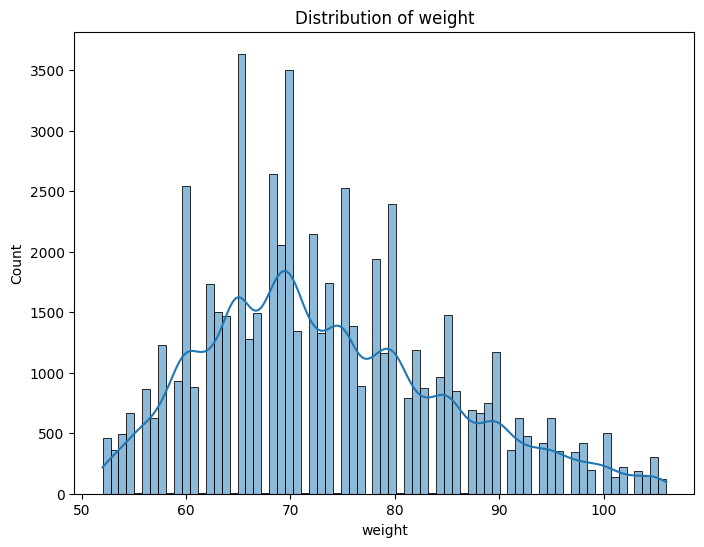

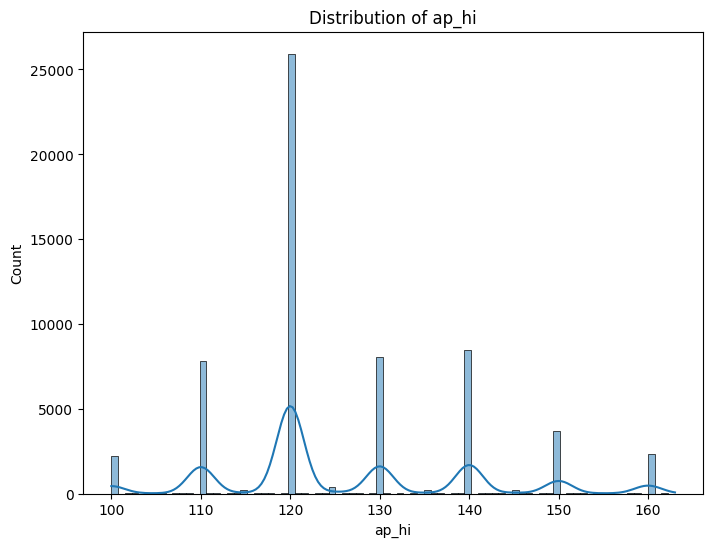

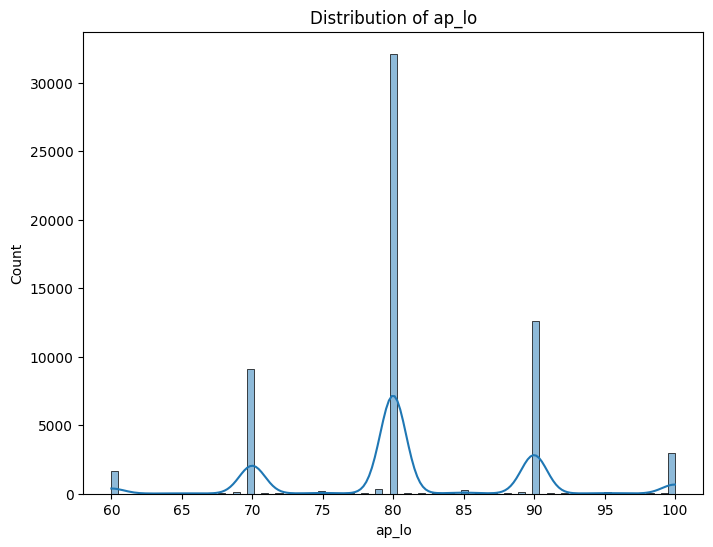

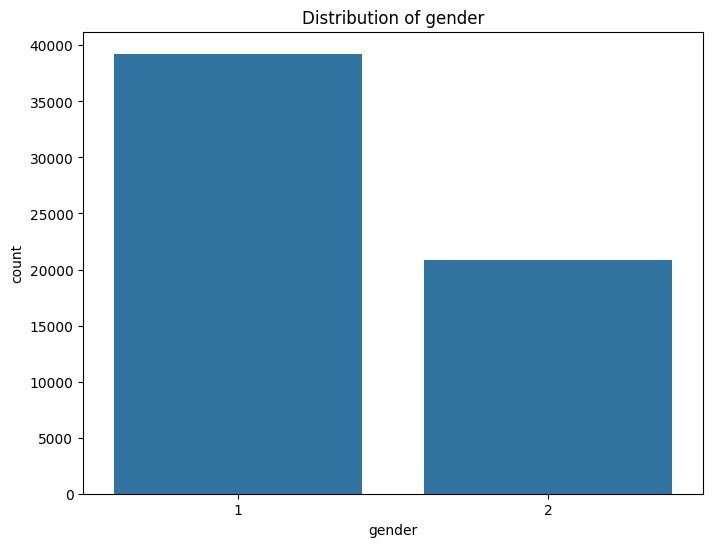

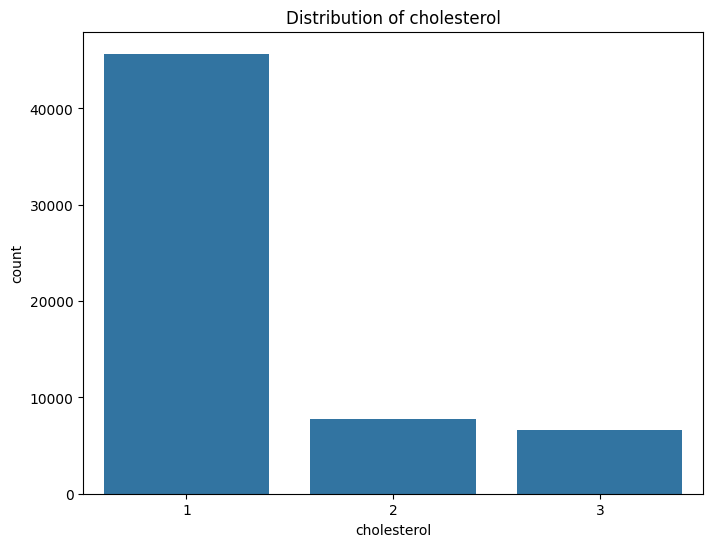

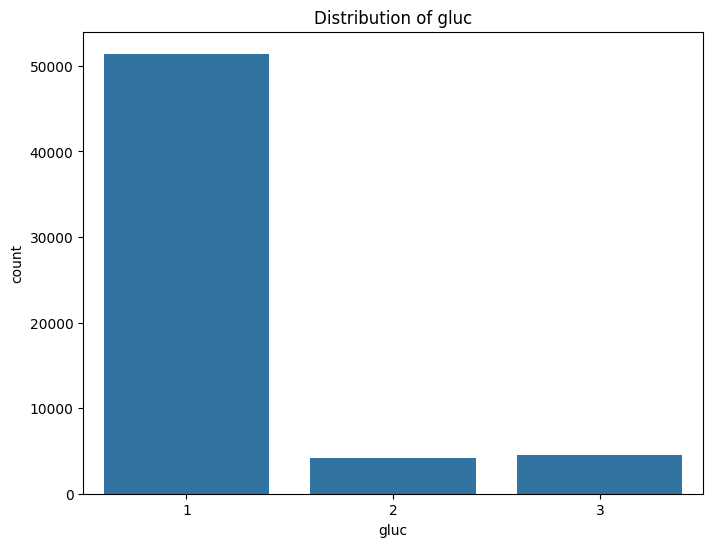

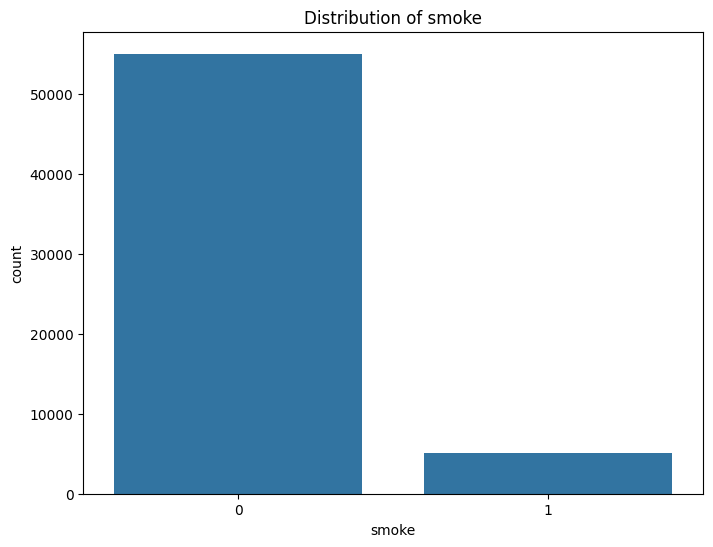

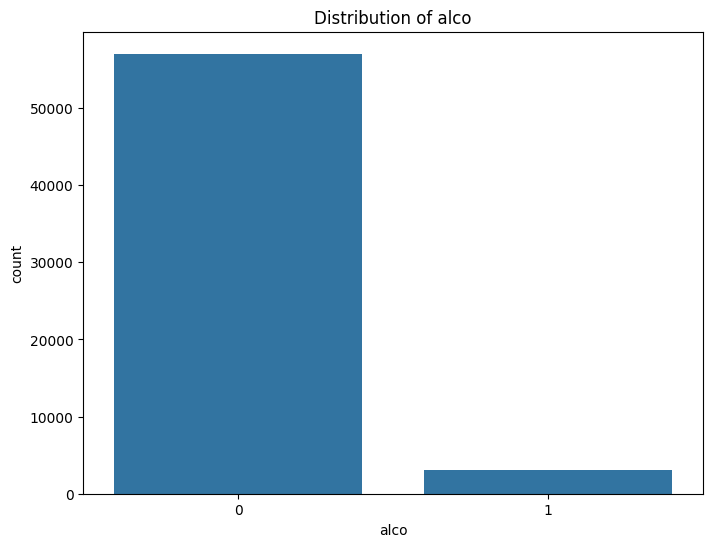

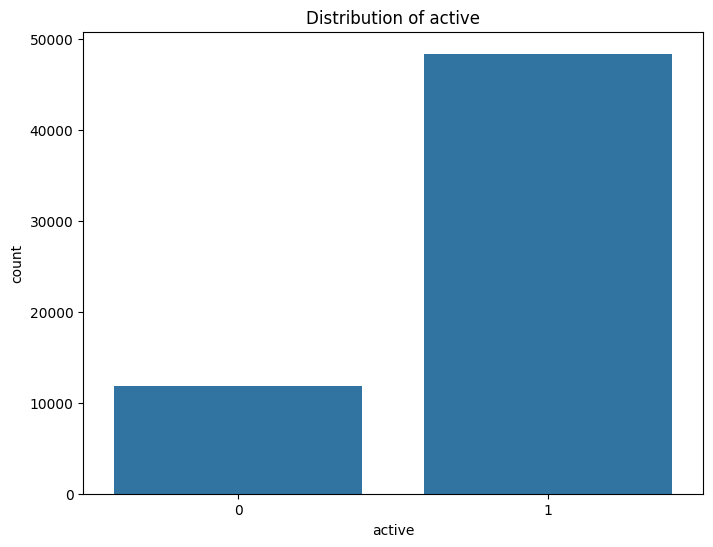

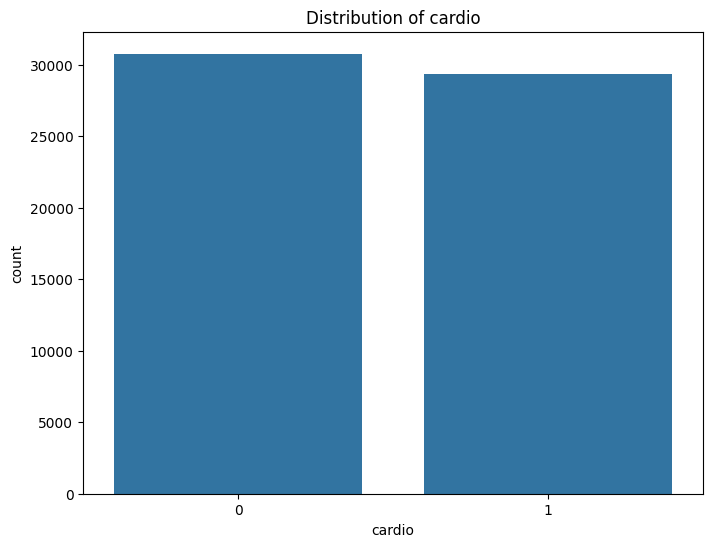

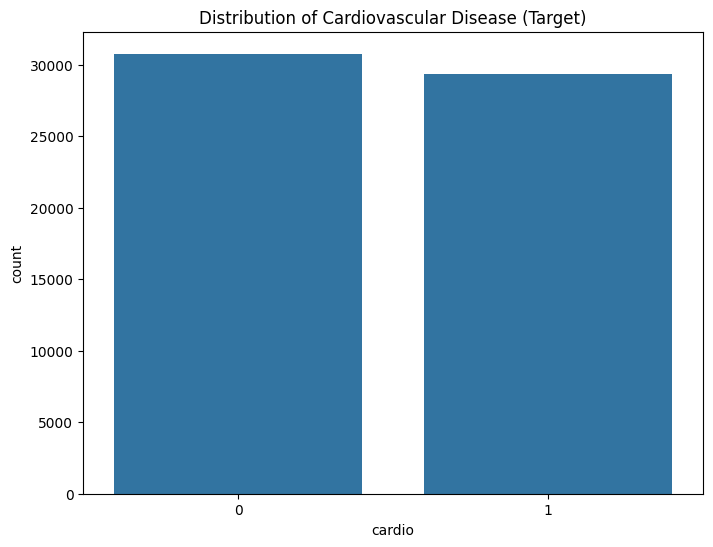

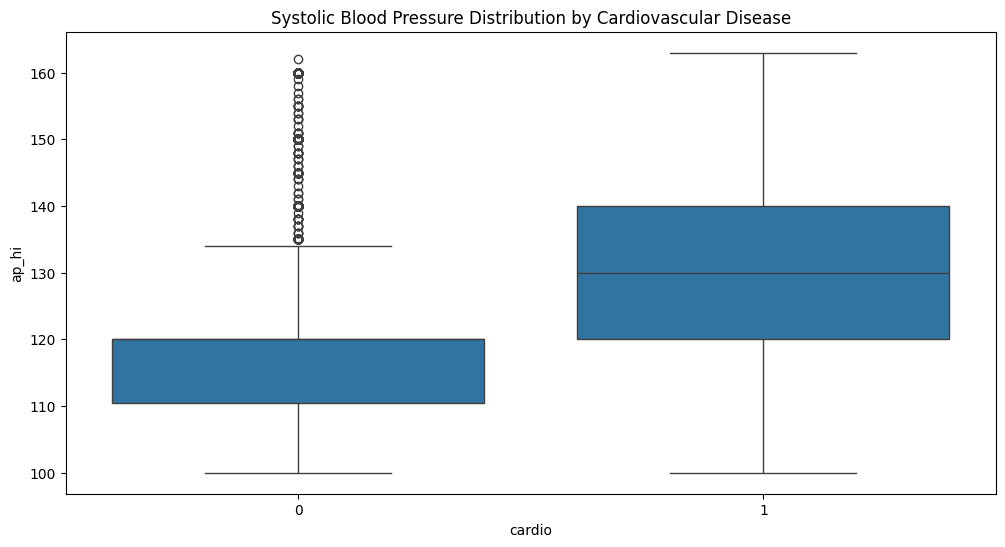

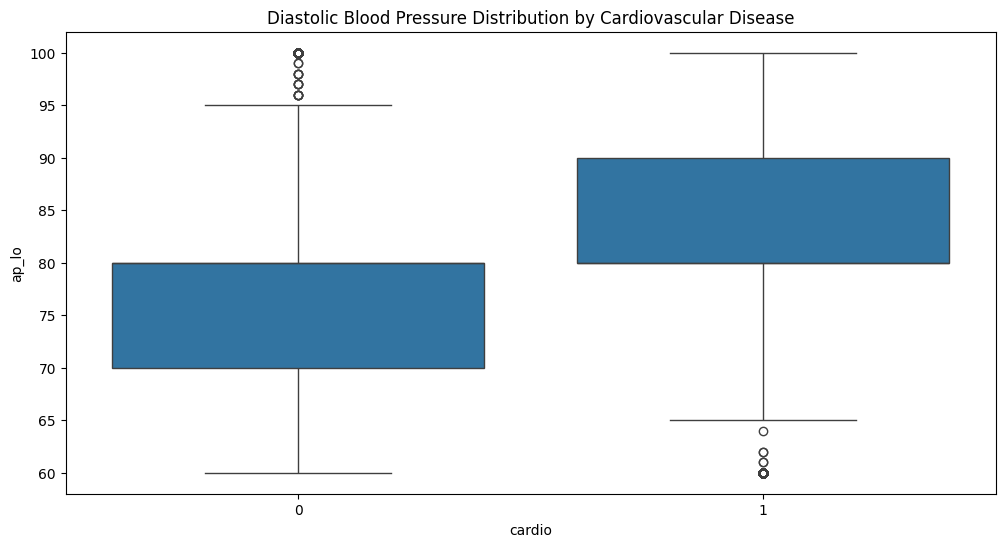

<AxesSubplot: xlabel='years', ylabel='count'>

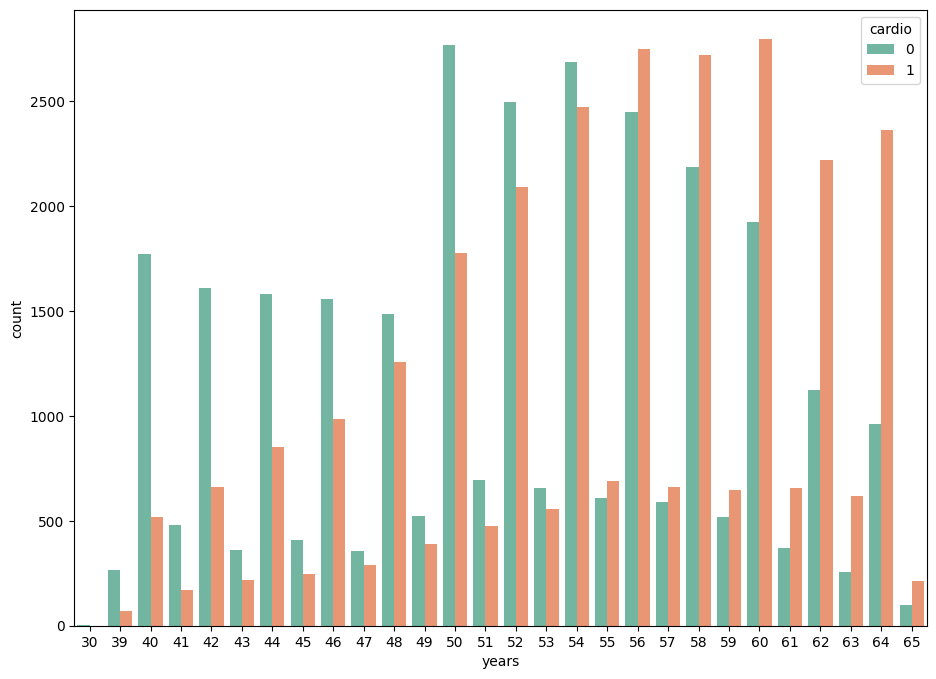

In [10]:
#Import the Cardiovascular Disease dataset
data = pd.read_csv('./archive/cardio_train.csv', sep=";")


#Quick overview of the data and important stats
data.head() #to visualize the first 5 rows of the dataset
data.info() #to check the data type for each variable; all features are numerical, 11 of integer type and 1 of decimal type
data.describe() #to identify important statistics for each variable (e.g. mean, standard deviation, min, max, etc.); one can spot the outliers in height, weight, ap_hi, api_lo


#Are there null values?What about duplicates?
print(data.isnull().sum()) #check for null values

print(f"Number of duplicate rows: {data.duplicated().sum()}") #display the number of duplicate values
duplicate_count = data.duplicated().sum()
if duplicate_count > 0:
    data = data.drop_duplicates() #remove duplicates if applicable


#data transformation, removing outliers, and interesting findings
data['years'] = (data['age'] / 365).round().astype('int') #in order to have a more appropriate format for age
data['cardio'].value_counts(normalize=True) #to balance the target variable
data['bmi'] = data['weight'] / (data['height']/100)**2 #include the BMI variable
data.drop('id', axis=1, inplace=True) #id column is not vital for modeling
data.drop('age', axis=1, inplace=True) #not needed after calculating the age
data.describe()
data.info()
len(data)


data.drop(data[(data['height'] > data['height'].quantile(0.975)) | (data['height'] < data['height'].quantile(0.025))].index,inplace=True) #remove outliers => remove heights that fall below 2.5% or above 97.5% of a given range
data.drop(data[(data['weight'] > data['weight'].quantile(0.975)) | (data['weight'] < data['weight'].quantile(0.025))].index,inplace=True) #remove outliers => remove weights that fall below 2.5% or above 97.5% of a given range
data.drop(data[(data['ap_hi'] > data['ap_hi'].quantile(0.975)) | (data['ap_hi'] < data['ap_hi'].quantile(0.025))].index,inplace=True) #remove outliers => remove systolic blood pressure values that fall below 2.5% or above 97.5% of a given range
data.drop(data[(data['ap_lo'] > data['ap_lo'].quantile(0.975)) | (data['ap_lo'] < data['ap_lo'].quantile(0.025))].index,inplace=True) #remove outliers => remove diastolic blood pressure values that fall below 2.5% or above 97.5% of a given range
len(data)

data.groupby('gender')['height'].mean() #on average, men are taller than women
data.groupby('gender')['alco'].sum() #on average, men drink more than women

#1.Create histograms for numerical features
numerical_features = ['years', 'height', 'weight', 'ap_hi', 'ap_lo']
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

#2.Create count plots for categorical features
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.show()
      
#3.Explore the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='cardio')
plt.title('Distribution of Cardiovascular Disease (Target)')
plt.show()

#4.The distribution of systolic blood pressure with respect to the target variable
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='cardio', y='ap_hi')
plt.title('Systolic Blood Pressure Distribution by Cardiovascular Disease')
plt.show()

#5.The distribution of diastolic blood pressure with respect to the target variable
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='cardio', y='ap_lo')
plt.title('Diastolic Blood Pressure Distribution by Cardiovascular Disease')
plt.show()

#6.Exposure to CVD based on age
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='years', hue='cardio', data = data, palette="Set2")

In [12]:
data

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,years,bmi
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,1,172,70.0,130,90,1,1,0,0,1,1,54,23.661439
69994,1,165,80.0,150,80,1,1,0,0,1,1,58,29.384757
69995,2,168,76.0,120,80,1,1,1,0,1,0,53,26.927438
69998,1,163,72.0,135,80,1,2,0,0,0,1,61,27.099251


## Data modeling

In [35]:
#Features and Target
X = data[['years', 'height', 'weight', 'ap_hi', 'ap_lo', 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi']]
y = data['cardio']

#Ensure that y is a 1D array
y = y.values.ravel()

#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#Initialize the Random Forest Classifier
#RFmodel = RandomForestClassifier(n_estimators = 100, criterion='entropy', max_depth=10, random_state = 42)
#RFmodel = RandomForestClassifier(n_estimators = 150, criterion='entropy',  max_depth=20, random_state = 42)
RFmodel = RandomForestClassifier(n_estimators=150, max_depth=6, max_features=None, random_state=42)

#Fit the model
RFmodel.fit(X_train, y_train)

#Predict on the test set
y_pred = RFmodel.predict(X_test)

#Assessment of the model
##1.Accuracy
accuracy = round(accuracy_score(y_test, y_pred), 4)
print(f'The accuracy of the Random Forest Classifier is: {accuracy}')

##2.Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'The Confusion Matrix of the Random Forest Classifier is: {conf_matrix}')

##3.Classification Report
class_report = classification_report(y_test, y_pred)
print(f'The Classification Report of the Random Forest Classifier is:\n{class_report}')

##4.Precision
precision = round(precision_score(y_test, y_pred), 4)
print(f'The precision of the Random Forest Classifier is: {precision}')

##5.Recall
recall = round(recall_score(y_test, y_pred), 4)
print(f'The recall of the Random Forest Classifier is: {recall}')

##6.F1-score
#f1 = round(f1_score(y_test, y_pred), 4)
#print(f'The F1-score of the Random Forest Classifier is: {f1}')

##7.ROC-AUC score
y_pred_proba = RFmodel.predict_proba(X_test)[:, 1]
roc_auc= round(roc_auc_score(y_test, y_pred_proba), 4)
print(f'The ROC-AUC of the Random Forest Classifier is: {roc_auc}')

##8.Metrics altogether
metrics_rf = pd.DataFrame({
    'Metrics': ['Accuracy', 'Precision', 'Recall', 'ROC-AUC'],
    'Scores' : [accuracy, precision, recall, roc_auc]
})
print(metrics_rf)

The accuracy of the Random Forest Classifier is: 0.7215
The Confusion Matrix of the Random Forest Classifier is: [[6133 1533]
 [2654 4716]]
The Classification Report of the Random Forest Classifier is:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      7666
           1       0.75      0.64      0.69      7370

    accuracy                           0.72     15036
   macro avg       0.73      0.72      0.72     15036
weighted avg       0.73      0.72      0.72     15036

The precision of the Random Forest Classifier is: 0.7547
The recall of the Random Forest Classifier is: 0.6399
The ROC-AUC of the Random Forest Classifier is: 0.788
     Metrics  Scores
0   Accuracy  0.7215
1  Precision  0.7547
2     Recall  0.6399
3    ROC-AUC  0.7880


In [34]:
# X = data[['years', 'height', 'weight', 'ap_hi', 'ap_lo', 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi']]
test_array = [[21, 181, 90, 120, 80, 1, 1, 2, 0, 0, 1, 27.471688898]]
test_data = RFmodel.predict(test_array)
test_data

/home/aryaman-gupta/Desktop/batcave/open-source-proj/env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0])